## DNN Optimization Application

In deep learning, specificly, forward and backward propagation, we use gradient descent to train the parameters. We expect that at some point, we will reach the optima that could minimize the cost function. Hence, we could get the most optimal performance of our algorithm. And with gradient descent, we assume that no matter where we start, we will always reach the minimum if the activation function is convex. However, in practice, we know that choosing the initial parameters is importance. We know that there are different types of technique to **initialize parameters** weights and bias for our networks. In this application, we will demonstrate how using different techniques for parameters initialization will affect the performance of out algorithms.

Another aspect is **overfitting**. Deep learning neural networks work so well on almost every dataset, so overfitting has become a problem that we need to address while using it. In this section, we will look at L2 regularization and dropout techniques that help prevent overfitting.

Lastly, during backrpop, we compute the derivatives of the weight, dW, and bias, db. In order to check if our backprop works correctly or not, we will check it using the definition of derivatives. Using **gradient checking**, we know if our gradient computing is correct or not. In case of wrong computation, we can also go back and check our algorithms to debug and fix the issue.

In this application, we have three sections:

**I. Initializing parameters using:**

a. Zeros initialization: initilize both weight and bias to zeros

b. Random initilization: randomly initilize the weights that take values from 0 to 1 and initialize b to zeros.

c. He initialization: randomly initialize the weights and scaled it by $\sqrt{\frac{2}{n^{[l-1}}}$, and initialize b to zeros.

d. Xavier initilization: randomly inititalize the weights and scaled it by $\sqrt{\frac{1}{n^{[l-1}}}$ or $\sqrt{\frac{1}{n^{[l-1]}+ n^{[l]}}}$

**II. Regularization for overfitting:**

a. L2 Regularization: Adding a L2 regularization term $\frac{\lambda}{2m}\sum\limits_{l=1}^L ||w^{[l]}||^2$ where $||w^{[l]}||^2= \sum\limits_{i=1}^{n^{[l]}}\sum\limits_{j=1}^{n^{[l-1]}} (w_{i,j}^{[l]})^2$ is the **Frobenius norm** and $\alpha$ is a regularization parameter. L2 regularization doesn't affect forwardprop, but it does change the cost the backprop. Hence, we will need to update our cost function, as well as our backprop algorithm. To understand more how L2 regularization reduces overfitting, we can check [my note](https://www.notion.so/Course-2-Improving-Deep-Neural-Networks-Hyperparameter-tuning-Regularization-and-Optimization-4b5bf738a90944fe83a03502bbaf99cb)

b. Dropout or Inverted dropout: The intuiation is that when we go through each layer, we will shutdown some node in that layer with a propability of (1-keep_prob), where keep_prob is the probability that we will keep the node in the layers. Computer vision is one of the application that we often use dropout technique as its data has very high features. We don't apply dropout to the input layer and output layer. Also, dropout should only be applied during training, not testing.

**III. Gradient checking:**

During backprop, we compute the derivatives of the weight and bias for each layer. To make sure that the backprop algorithm works properly, we will check if our gradients is correct. Using the defition of derivative: $f'(\theta) = \lim\limits_{\epsilon \rightarrow} \frac{f(\theta + \epsilon) - f(\theta - \epsilon)}{2\theta}$. This two sided difference has an error of $O(\epsilon^2)$ whereas one sided difference ($f'(\theta) = \lim\limits_{\epsilon \rightarrow} \frac{f(\theta + \epsilon) - f(\theta)}{\theta}$) of $O(\epsilon)$ for a very small $\epsilon$. Hence, the two sided difference is more accurate and used for gradient checking algorithm.


### Load needed libraries

- Numpy is needed for mathematical calculations.
- matplotlib.pyplot: used for plotting.
- sklearn and sklearn.datasets: loading datasets for this project. There are two datasets.
- .py files: contains functions that needed for initilizing parameters, computing activation functions, forward, backward algorithms, and so on.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn
import sklearn.datasets
from path import my_path
from dnn_utils import initialize_parameters_deep, load_2D_dataset, load_dataset
from deep_learning_algorithms import deep_neural_net_opt, predict, L_forward


### Creating some functions that help with visualization

In [2]:

def visualize_data(train_X, train_Y):
    plt.scatter(train_X[:,0], train_X[:,1], c=train_Y, s= 40, cmap = plt.cm.Spectral)
def plot_cost(costs, learning_rate):
    plt.plot(costs)
    plt.ylabel('cost')
    plt.xlabel('iteration (per hundreds)')
    plt.title("Learning_rate ="+ str(learning_rate))
    plt.show
    
def plot_decision_boundary(model, X, y):
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    Z = model(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, cmap=plt.cm.Spectral)
    plt.show()
def predict_dec(parameters, X):
    """
    Used for plotting decision boundary.
    
    Arguments:
    parameters -- python dictionary containing your parameters 
    X -- input data of size (m, K)
    
    Returns
    predictions -- vector of predictions of our model (red: 0 / blue: 1)
    """
    
    # Predict using forward propagation and a classification threshold of 0.5
    a3, cache = L_forward(X, parameters)
    predictions = (a3>0.5)
    return predictions

%matplotlib inline
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

%load_ext autoreload
%autoreload 2
    

## I. Initialize parameters.

First, we will load a dataset that we could use later to show how initialization could affect our algorithm performance.

X train has shape of : (300, 2)
Y train has shape of:  (300,)


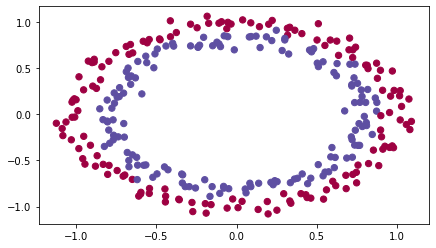

In [3]:
train_X_orig, train_Y_orig, test_X_orig, test_Y_orig = load_dataset()
print("X train has shape of :", train_X_orig.shape)
print("Y train has shape of: ",train_Y_orig.shape)
#Plot the data 
visualize_data(train_X_orig, train_Y_orig)

X train has 300 examples and each training example has 2 features ($n_x$ = 2). Y train is a rank 1 vector. To apply our network, we need to reshape both the training and testing sets to make sure that train_X has shape of (2, 300), train_Y is not a rank-1 matrix and has shape of (300, 1). The same goes for test set.

In [4]:
#Change shape of the data to correct dimension
train_X = train_X_orig.T
train_Y = train_Y_orig.reshape((1, train_Y_orig.shape[0]))
test_X = test_X_orig.T
test_Y = test_Y_orig.reshape((1, test_Y_orig.shape[0]))
print(" Train X has shape:", train_X.shape, "\n", "Train Y has shape:", train_Y.shape)
print(" Test X has shape:", test_X.shape, "\n", "Test Y has shape:", test_Y.shape)

 Train X has shape: (2, 300) 
 Train Y has shape: (1, 300)
 Test X has shape: (2, 100) 
 Test Y has shape: (1, 100)


Now that our datasets has correct dimension. We will apply neural network to our dataset using different parameter initialization techniques.

First, we will define $n_x$ and also the layer_sizes list which contains the number of nodes or units in each layer. We use a 3 layer neural networks to train our dataset.

In [5]:
n_x = train_X.shape[0]
layer_sizes = [n_x, 10, 5, 1] #3 layers neural networks

#### Zeros initialization: Initialize weights and bias to zeros:

Neural networks with zeros initialization perform poorly on the dataset. Both the train and test accuracy is around 50%.

In [6]:
# zeros initialization
parameters, grads, costs = deep_neural_net_opt(train_X, train_Y, initialization='zeros', layer_sizes = layer_sizes, learning_rate = 0.01, num_iterations = 15000, print_cost=True)
train_pred, accuracy = predict(train_X, train_Y, parameters)
print("train accuracy with 'zeros': ", accuracy)
test_pred, accuracy = predict(test_X, test_Y, parameters)
print("test accuracy with 'zeros': ", accuracy)


Cost at 0th iteration is: 0.6931471805599453
Cost at 1000th iteration is: 0.6931471805599453
Cost at 2000th iteration is: 0.6931471805599453
Cost at 3000th iteration is: 0.6931471805599453
Cost at 4000th iteration is: 0.6931471805599453
Cost at 5000th iteration is: 0.6931471805599453
Cost at 6000th iteration is: 0.6931471805599453
Cost at 7000th iteration is: 0.6931471805599453
Cost at 8000th iteration is: 0.6931471805599453
Cost at 9000th iteration is: 0.6931471805599453
Cost at 10000th iteration is: 0.6931471805599453
Cost at 11000th iteration is: 0.6931471805599453
Cost at 12000th iteration is: 0.6931471805599453
Cost at 13000th iteration is: 0.6931471805599453
Cost at 14000th iteration is: 0.6931471805599453
train accuracy with 'zeros':  0.49999999999999994
test accuracy with 'zeros':  0.5


In [7]:
print("train predictions: "+str(train_pred))
print("test predictions: "+ str(test_pred))

train predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
  0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
test predictions: [[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 

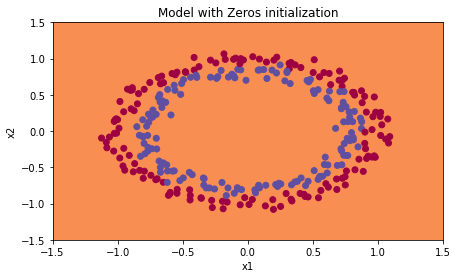

In [8]:
plt.title("Model with Zeros initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### Random intialization: randomly initialize the weights.

We still initialize b to zeros, but we initialize weights randomly using np.random.randn() and scaled it to different factors.

If we choose a good scaled factor (in this case, 0.01), random initialization will be better than zeros initialization (the accuracy increases 53%). However, if we choose a bad scaled factor (like 5), random initialization is as bad as zeros initialization. That is because when we use a large scaled factor, it might leed to large initialization. With sigmoid and tanh functions, too large or too small initialization might leed to vanishing or exploding gradients which cause the network to learn very slow and perform bad.


/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:95: RuntimeWarning: divide by zero encountered in log
  log_loss = -np.dot(Y, np.log(AL).T) - np.dot(1 - Y, np.log(1 - AL).T)
/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:158: RuntimeWarning: divide by zero encountered in true_divide
  dAL = -(np.divide(Y, AL) - np.divide((1 - Y), (1 - AL)))
/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:158: RuntimeWarning: invalid value encountered in true_divide
  dAL = -(np.divide(Y, AL) - np.divide((1 - Y), (1 - AL)))
/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/dnn_utils.py:17: RuntimeWarning: invalid value encountered in multiply
  dZ = dA * s * (1-s)


Cost at 0th iteration is: nan
Cost at 1000th iteration is: nan
Cost at 2000th iteration is: nan
Cost at 3000th iteration is: nan
Cost at 4000th iteration is: nan
Cost at 5000th iteration is: nan
Cost at 6000th iteration is: nan
Cost at 7000th iteration is: nan
Cost at 8000th iteration is: nan
Cost at 9000th iteration is: nan
Cost at 10000th iteration is: nan
Cost at 11000th iteration is: nan
Cost at 12000th iteration is: nan
Cost at 13000th iteration is: nan
Cost at 14000th iteration is: nan
train accuracy with 'xavier'':  0.49999999999999994
test accuracy with 'xavier':  0.5


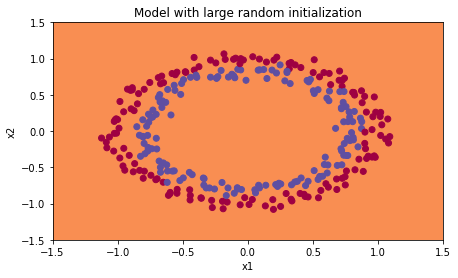

In [9]:
# #Random initialization with a scaled factor of 5
parameters, grads, costs = deep_neural_net_opt(train_X, train_Y, initialization='random', 
                                        layer_sizes = layer_sizes, learning_rate = 0.01, num_iterations = 15000,random_scaled=5, print_cost=True)
_, accuracy = predict(train_X, train_Y, parameters)
print("train accuracy with 'xavier'': ", accuracy)
_, accuracy = predict(test_X, test_Y, parameters)
print("test accuracy with 'xavier': ", accuracy)

plt.title("Model with large random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

Cost at 0th iteration is: 0.6931473549048266
Cost at 1000th iteration is: 0.6931473504885134
Cost at 2000th iteration is: 0.6931473468317759
Cost at 3000th iteration is: 0.6931473432446152
Cost at 4000th iteration is: 0.6931473396813664
Cost at 5000th iteration is: 0.6931473361903396
Cost at 6000th iteration is: 0.6931473327310922
Cost at 7000th iteration is: 0.6931473293491259
Cost at 8000th iteration is: 0.6931473260187053
Cost at 9000th iteration is: 0.6931473227372424
Cost at 10000th iteration is: 0.6931473195009529
Cost at 11000th iteration is: 0.6931473163278133
Cost at 12000th iteration is: 0.693147312959552
Cost at 13000th iteration is: 0.6931473097541098
Cost at 14000th iteration is: 0.6931473065831707
train accuracy with 'random', scaled = 0.01:  0.4633333333333333
test accuracy with 'random',scaled = 0.01:  0.48000000000000004


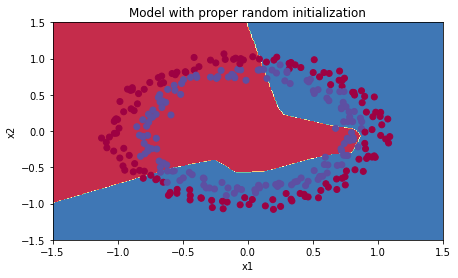

In [10]:
# #Random initialization
parameters, grads, costs = deep_neural_net_opt(train_X, train_Y, initialization='random', 
                                        layer_sizes = layer_sizes, learning_rate = 0.01, num_iterations = 15000,random_scaled=0.01, print_cost=True)
_, accuracy = predict(train_X, train_Y, parameters)
print("train accuracy with 'random', scaled = 0.01: ", accuracy)
_, accuracy = predict(test_X, test_Y, parameters)
print("test accuracy with 'random',scaled = 0.01: ", accuracy)

plt.title("Model with proper random initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### He initialization:
With He initialization, the networks work much better than random and zeros initialization. The cost reduces after each iteration and the accuracy increases from 50% to 94%.

Cost at 0th iteration is: 0.7063537226761785
Cost at 1000th iteration is: 0.6841673481541337
Cost at 2000th iteration is: 0.6743005005380616
Cost at 3000th iteration is: 0.6599829227378975
Cost at 4000th iteration is: 0.6265468981218963
Cost at 5000th iteration is: 0.5696674283182764
Cost at 6000th iteration is: 0.4852410365681537
Cost at 7000th iteration is: 0.3838051751444053
Cost at 8000th iteration is: 0.2934483275967974
Cost at 9000th iteration is: 0.22776369569327823
Cost at 10000th iteration is: 0.1832862069776236
Cost at 11000th iteration is: 0.15343012741586237
Cost at 12000th iteration is: 0.13416070927118293
Cost at 13000th iteration is: 0.11993174710141295
Cost at 14000th iteration is: 0.09323576900214212
train accuracy with 'He'':  0.9800000000000001
test accuracy with 'He':  0.94


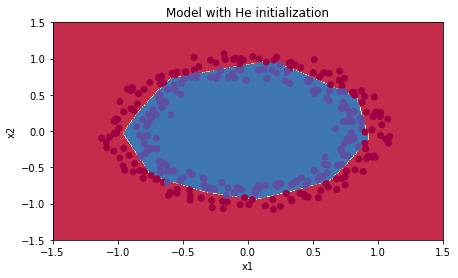

In [11]:
parameters, grads, costs = deep_neural_net_opt(train_X, train_Y, initialization='he', layer_sizes = layer_sizes, learning_rate = 0.01, num_iterations = 15000, print_cost=True)
_, accuracy = predict(train_X, train_Y, parameters)
print("train accuracy with 'He'': ", accuracy)
_, accuracy = predict(test_X, test_Y, parameters)
print("test accuracy with 'He': ", accuracy)
plt.title("Model with He initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### Xavier initialization

Similar to He initialization, Xavier initialization also works much better than random and zeros initialization. In fact, He and Xavier initializations are very similar as the scaled factor of Xavier initialization is $\sqrt{2}$ times the scaled factor of He initialization

Cost at 0th iteration is: 0.729451703805014
Cost at 1000th iteration is: 0.6939441869897983
Cost at 2000th iteration is: 0.686361215705118
Cost at 3000th iteration is: 0.6783983102177118
Cost at 4000th iteration is: 0.6642724691723297
Cost at 5000th iteration is: 0.6361798618357726
Cost at 6000th iteration is: 0.5845947883351541
Cost at 7000th iteration is: 0.4968293476934554
Cost at 8000th iteration is: 0.38924801157180833
Cost at 9000th iteration is: 0.2944433152121502
Cost at 10000th iteration is: 0.22861336401979623
Cost at 11000th iteration is: 0.1831478786638718
Cost at 12000th iteration is: 0.150080097183777
Cost at 13000th iteration is: 0.12676127493737516
Cost at 14000th iteration is: 0.10850689140892152
train accuracy with 'xavier'':  0.9900000000000002
test accuracy with 'xavier':  0.9299999999999999


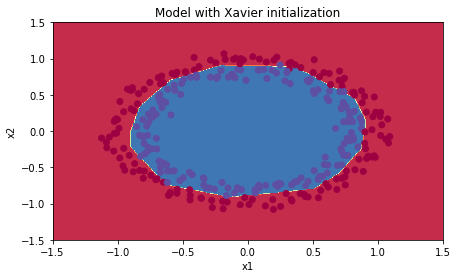

In [12]:
parameters, grads, costs = deep_neural_net_opt(train_X, train_Y, initialization='xavier',xavier_option=None, layer_sizes = layer_sizes, learning_rate = 0.01, num_iterations = 15000, print_cost=True)
_, accuracy = predict(train_X, train_Y, parameters)
print("train accuracy with 'xavier'': ", accuracy)
_, accuracy = predict(test_X, test_Y, parameters)
print("test accuracy with 'xavier': ", accuracy)
plt.title("Model with Xavier initialization")
axes = plt.gca()
axes.set_xlim([-1.5,1.5])
axes.set_ylim([-1.5,1.5])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## II. Regularization

We will use a French football dataset for both regularization and gradient checking section. We will use a neural network model with 3 layers to predict positions where France's goal keeper should kick the ball so that their team players can then hit it with their head. We will see how a 3 layers neural network overfit the dataset, and how applying L2 regularization or dropout help prevent overfitting.


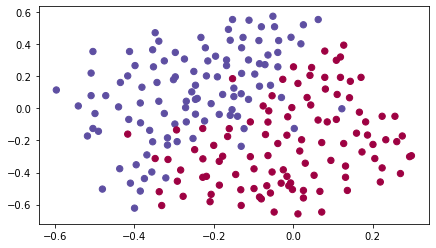

In [13]:
# loading and plotting the dataset
train_X, train_Y, test_X, test_Y = load_2D_dataset(my_path)
plt.scatter(train_X[0, :], train_X[1, :], c= train_Y, s = 40, cmap = plt.cm.Spectral)

We want to train a 3 layers neural network that has:
- 20 neurons in the first hidden layer
- 3 neurons in the second hidden layer
- 1 neuron in the output layer.

We use xavier initialization technique to initilize parameters. learning_rate = 0.3 and number of iterations is 30,000.

This baseline model results in an train accuracy of 94.8% and test accuracy of 91.5%. It is a quiet good result as the accuracies are high and the difference between training and testing accuracy is not big (but it stills indicates the overfitting problem). As we later apply L2 and dropout regularization techniques, we will see the impact of reglurazation on this model.


Cost at 0th iteration is: 0.6557412523481002
Cost at 1000th iteration is: 0.22226693868451147
Cost at 2000th iteration is: 0.20288702607598852
Cost at 3000th iteration is: 0.1825149792468696
Cost at 4000th iteration is: 0.1805397830621775
Cost at 5000th iteration is: 0.17620471758400444
Cost at 6000th iteration is: 0.1683273039211542
Cost at 7000th iteration is: 0.1658359365467297
Cost at 8000th iteration is: 0.16312671914460508
Cost at 9000th iteration is: 0.1594261225324511
Cost at 10000th iteration is: 0.163299875257242
Cost at 11000th iteration is: 0.16098614487789195
Cost at 12000th iteration is: 0.1576447414819299
Cost at 13000th iteration is: 0.15213599644222867
Cost at 14000th iteration is: 0.1484371351897736
Cost at 15000th iteration is: 0.14796400922574293
Cost at 16000th iteration is: 0.14634876306350142
Cost at 17000th iteration is: 0.14634375863077503
Cost at 18000th iteration is: 0.14335088537382412
Cost at 19000th iteration is: 0.1393648836231267
Cost at 20000th iteratio

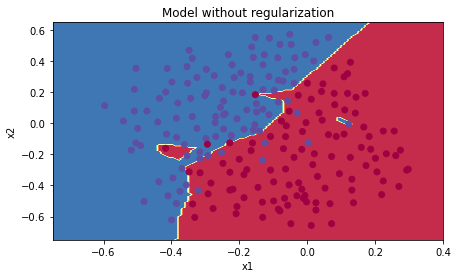

In [14]:

layer_sizes = [train_X.shape[0], 20, 3, 1]

parameters, _, _ = deep_neural_net_opt(train_X, train_Y, initialization='xavier',layer_sizes=layer_sizes, learning_rate = 0.3,
                                      num_iterations = 30000, print_cost = True)

print("On the train set:")
train_pred, accuracy = predict(train_X, train_Y, parameters)
print(accuracy)
print("On the test set:")
test_pred, accuracy = predict(test_X, test_Y, parameters)
print(accuracy)

plt.title("Model without regularization")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### L2 regularization

With the baseline model, there is a light overfitting issue. This section, we apply L2 regularization with the regularized parameter $\lambda = 0.7$ and hope that it will help reduce overfitting.

We could see that, with L2 regularization, the test accuracy increased to 93% and train accuracy is 93.8. It means we have reduced the overfitting using L2 regularization.

Cost at 0th iteration is: 0.6974484493131264
Cost at 1000th iteration is: 0.27304563479326766
Cost at 2000th iteration is: 0.26985760798332925
Cost at 3000th iteration is: 0.2695082806412659
Cost at 4000th iteration is: 0.2692654449361621
Cost at 5000th iteration is: 0.2690430474349705
Cost at 6000th iteration is: 0.2688974560734562
Cost at 7000th iteration is: 0.2687751717855724
Cost at 8000th iteration is: 0.268673250206026
Cost at 9000th iteration is: 0.2685595174585008
Cost at 10000th iteration is: 0.2684918873282238
Cost at 11000th iteration is: 0.2684141282822975
Cost at 12000th iteration is: 0.268370115369031
Cost at 13000th iteration is: 0.2683177401855034
Cost at 14000th iteration is: 0.2682670489347798
Cost at 15000th iteration is: 0.2682199033729047
Cost at 16000th iteration is: 0.26816870547972715
Cost at 17000th iteration is: 0.2681517100224052
Cost at 18000th iteration is: 0.2681331699914915
Cost at 19000th iteration is: 0.2680892379993576
Cost at 20000th iteration is: 0.

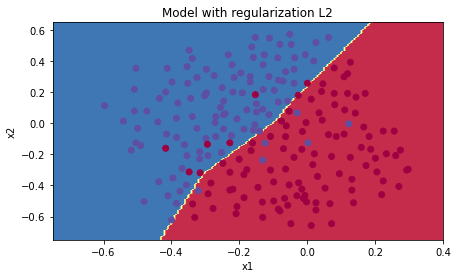

In [15]:
#Model with L2 regularization
parameters, _, _ = deep_neural_net_opt(train_X, train_Y, initialization='xavier',layer_sizes=layer_sizes, learning_rate = 0.3,
                                      num_iterations = 30000,lambd = 0.7, print_cost = True)

print("On the train set:")
train_pred, accuracy = predict(train_X, train_Y, parameters)
print(accuracy)
print("On the test set:")
test_pred, accuracy = predict(test_X, test_Y, parameters)
print(accuracy)

plt.title("Model with regularization L2")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

#### Dropout

We've shown that L2 regularization reduces overfitting on our network. Now, we will apply dropout and see how dropout help handling overfitting issue. We will use keep_prob = 0.86 and we will apply dropout on layers 1 and 2.

It shows that dropout works great as the test accuracy increase to 93.4% and the model is not overfitting the training set.


Cost at 0th iteration is: 0.6529794429532378
Cost at 1000th iteration is: 0.09680546726848972
Cost at 2000th iteration is: 0.04588455053104561


/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:121: RuntimeWarning: divide by zero encountered in log
  logprobs = np.multiply(-np.log(AL), Y) + np.multiply(-np.log(1-AL), 1 - Y)
/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:121: RuntimeWarning: invalid value encountered in multiply
  logprobs = np.multiply(-np.log(AL), Y) + np.multiply(-np.log(1-AL), 1 - Y)
/Users/gabati/Documents/GitHub/ML/deep_learning_optimization/deep_learning_algorithms.py:214: RuntimeWarning: invalid value encountered in true_divide
  dAL = (-np.divide(Y, AL) + np.divide((1 - Y), (1 - AL)))


Cost at 3000th iteration is: 0.028943710277957887
Cost at 4000th iteration is: 0.02323352411510686
Cost at 5000th iteration is: 0.020807585636122023
Cost at 6000th iteration is: 0.019645652736656583
Cost at 7000th iteration is: 0.019077706621988492
Cost at 8000th iteration is: 0.018763727783023338
Cost at 9000th iteration is: 0.018562603802063142
Cost at 10000th iteration is: 0.0184537294432373
Cost at 11000th iteration is: 0.018372848309346136
Cost at 12000th iteration is: 0.018316502475991314
Cost at 13000th iteration is: 0.018275617280672576
Cost at 14000th iteration is: 0.018244038215645225
Cost at 15000th iteration is: 0.018218941599235258
Cost at 16000th iteration is: 0.018199851392171035
Cost at 17000th iteration is: 0.01818250402782685
Cost at 18000th iteration is: 0.018173851819655286
Cost at 19000th iteration is: 0.018154757798107577
Cost at 20000th iteration is: 0.018146817075306756
Cost at 21000th iteration is: 0.01813691424273748
Cost at 22000th iteration is: 0.01812819252

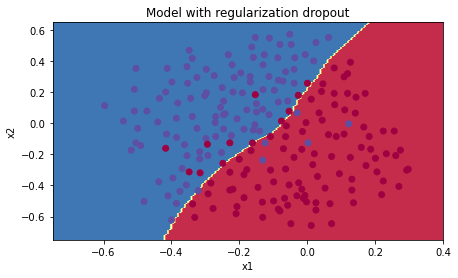

In [16]:
#Dropout
#Model with L2 regularization
# np.random.seed(1)
parameters, _, _ = deep_neural_net_opt(train_X, train_Y, initialization='xavier',layer_sizes=layer_sizes, 
                                       learning_rate = 0.3, num_iterations = 30000, keep_prob = 0.86,
                                       dropout_layers=[1,2], print_cost = True)

print("On the train set:")
train_pred, accuracy = predict(train_X, train_Y, parameters)
print(accuracy)
print("On the test set:")
test_pred, accuracy = predict(test_X, test_Y, parameters)
print(accuracy)

plt.title("Model with regularization dropout")
axes = plt.gca()
axes.set_xlim([-0.75,0.40])
axes.set_ylim([-0.75,0.65])
plot_decision_boundary(lambda x: predict_dec(parameters, x.T), train_X, train_Y)

## III. Gradients checking

We've seen how to initialize parameters and how to apply regularization to prevent overfitting. Now, we will check the gradients to make sure that our backprop algorithm is correct and working good.
Since gradient check is costly, we don't want to run it in every iteration. I will only run it for the first 10 iterations.



In [17]:
parameters, grads, _ = deep_neural_net_opt(train_X, train_Y, initialization='xavier',layer_sizes=layer_sizes, 
                                       learning_rate = 0.3, num_iterations = 10,
                                       dropout_layers=[1,2], print_cost = True, grad_check = True)


Your backward propagation works perfectly fine! difference = 1.3993885258802112e-08
Cost at 0th iteration is: 0.6557412523481002
Your backward propagation works perfectly fine! difference = 1.4156081989401306e-08
Your backward propagation works perfectly fine! difference = 1.538876283575572e-08
Your backward propagation works perfectly fine! difference = 1.6237396897361457e-08
Your backward propagation works perfectly fine! difference = 1.5003583282205467e-08
Your backward propagation works perfectly fine! difference = 1.3952565502858221e-08
Your backward propagation works perfectly fine! difference = 1.471650664119261e-08
Your backward propagation works perfectly fine! difference = 1.1427545097686088e-08
Your backward propagation works perfectly fine! difference = 1.1521359103755792e-08
Your backward propagation works perfectly fine! difference = 1.1988812758103159e-08
